In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

In [114]:
import re

with open('wmo121000iso.txt', 'r', encoding='ISO-8859-2') as file:
    lines = file.readlines()[1:5000]

data = [re.split(r'\s+', line.strip()) for line in lines]

columns = [
    'N', 'M', 'D', 'H', 'DBT', 'RH', 'HR', 'WS', 'WD',
    'ITH', 'IDH', 'ISH', 'TSKY',
    'N_0', 'N_30', 'NE_30', 'E_30', 'SE_30', 'S_30', 'SW_30', 'W_30', 'NW_30',
    'N_45', 'NE_45', 'E_45', 'SE_45', 'S_45', 'SW_45', 'W_45', 'NW_45',
    'N_60', 'NE_60', 'E_60', 'SE_60', 'S_60', 'SW_60', 'W_60', 'NW_60',
    'N_90', 'NE_90', 'E_90', 'SE_90', 'S_90', 'SW_90', 'W_90', 'NW_90'
]

df = pd.DataFrame(data, columns=columns)
df = df.drop(index=0)
df = df.apply(pd.to_numeric, errors='coerce')

def calculate_date(row):
    total_hours = row['N'] - 1
    remaining_hours = total_hours % 8760

    days_passed = remaining_hours // 24
    hour = row['H']

    month_days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

    month = 0
    while days_passed >= month_days[month]:
        days_passed -= month_days[month]
        month += 1

    day = days_passed + 1
    return pd.Timestamp(year=1992, month=int(month) + 1, day=int(day), hour=int(hour))

df['date'] = df.apply(calculate_date, axis=1)

df.set_index('date', inplace=True)

In [115]:
df.sample(5)

,N,M,D,H,DBT,RH,HR,WS,WD,ITH,...,W_60,NW_60,N_90,NE_90,E_90,SE_90,S_90,SW_90,W_90,NW_90
date,,,,,,,,,,,,,,,,,,,,,
1992-03-07 02:00:00,1563,3,7,2,3.1,84,3.896,2.0,15,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1992-06-13 20:00:00,3933,6,13,20,10.7,90,7.269,1.0,22,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1992-06-18 16:00:00,4049,6,18,16,14.4,68,6.915,3.0,31,209.3,...,233.7,225.2,191.8,189.2,189.2,189.2,189.2,215.4,228.9,219.1
1992-04-12 14:00:00,2439,4,12,14,7.8,60,3.872,3.0,28,297.7,...,335.2,285.0,241.8,241.8,241.8,241.8,292.5,331.1,317.4,259.3
1992-03-26 23:00:00,2040,3,26,23,2.4,89,4.058,2.0,11,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [116]:
selected_columns = ['DBT', 'RH', 'HR', 'WS', 'WD', 'ITH', 'IDH', 'ISH', 'TSKY']
n_hours = 24
df_selected = df[selected_columns][:-n_hours+1]

In [117]:
def test_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')

for column in selected_columns:
    print(f'Testing {column} for stationarity:')
    test_stationarity(df_selected[column])

df_selected_diff = df_selected.diff().dropna()

model = VAR(df_selected_diff)
lag_order = model.select_order(maxlags=50)
print(lag_order.summary())
model_fitted = model.fit(lag_order.aic)

print(model_fitted.summary())

last_values = df_selected_diff.values[-model_fitted.k_ar:]

forecast_diff = model_fitted.forecast(last_values, steps=n_hours)

forecast_index = pd.date_range(start=df_selected.index[-1] + pd.Timedelta(hours=1), periods=n_hours, freq='h')
forecast_df = pd.DataFrame(forecast_diff, index=forecast_index, columns=df_selected.columns)

forecast_level = forecast_df.cumsum() + df_selected.iloc[-1]

print(forecast_level)



Testing DBT for stationarity:
ADF Statistic: -2.365329794247503
p-value: 0.1517618136582518
Critical Values:
	1%: -3.431673629205833
	5%: -2.862124899494961
	10%: -2.5670813429654813
Testing RH for stationarity:
ADF Statistic: -8.759625979071052
p-value: 2.696145824563432e-14
Critical Values:
	1%: -3.4316738971778435
	5%: -2.8621250178829576
	10%: -2.567081405988135
Testing HR for stationarity:
ADF Statistic: -2.2897386039091727
p-value: 0.17529883694852738
Critical Values:
	1%: -3.431673629205833
	5%: -2.862124899494961
	10%: -2.5670813429654813
Testing WS for stationarity:
ADF Statistic: -9.148872581015235
p-value: 2.7206162586870877e-15
Critical Values:
	1%: -3.4316738971778435
	5%: -2.8621250178829576
	10%: -2.567081405988135
Testing WD for stationarity:
ADF Statistic: -8.025904132211584
p-value: 2.0177848376738294e-12
Critical Values:
	1%: -3.431672290971355
	5%: -2.862124308272982
	10%: -2.567081028234463
Testing ITH for stationarity:
ADF Statistic: -5.4347063671686575
p-value: 2

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        4.894       4.905       133.4       4.898
1        2.114       2.233       8.285       2.156
2        1.865       2.090       6.453       1.944
3        1.539       1.872       4.660       1.656
4        1.320       1.760       3.744       1.474
5        1.216       1.762       3.372       1.407
6        1.081      1.735*       2.948       1.310
7       0.9804       1.741       2.666       1.247
8       0.9394       1.807       2.559       1.244
9       0.8644       1.839       2.374       1.206
10      0.8218       1.903       2.275       1.201
11      0.7913       1.980       2.206       1.208
12      0.7347       2.030       2.085       1.189
13      0.6723       2.075       1.959       1.164
14      0.6358       2.145       1.889       1.165
15      0.5819       2.198       1.790       1.149
16      0.4989       2.222     

In [118]:
common_index = df_selected.index.intersection(forecast_level.index)
actual_values = pd.DataFrame(df[-n_hours:])
predicted_values = pd.DataFrame(forecast_level)
print(actual_values['DBT'])
print(predicted_values['DBT'])

date
1992-07-27 06:00:00    18.2
1992-07-27 07:00:00    20.7
1992-07-27 08:00:00    23.3
1992-07-27 09:00:00    25.8
1992-07-27 10:00:00    26.8
1992-07-27 11:00:00    27.7
1992-07-27 12:00:00    28.7
1992-07-27 13:00:00    26.4
1992-07-27 14:00:00    24.1
1992-07-27 15:00:00    21.8
1992-07-27 16:00:00    20.7
1992-07-27 17:00:00    19.7
1992-07-27 18:00:00    18.6
1992-07-27 19:00:00    18.3
1992-07-27 20:00:00    18.1
1992-07-27 21:00:00    17.8
1992-07-27 22:00:00    17.4
1992-07-27 23:00:00    17.1
1992-07-28 00:00:00    16.7
1992-07-28 01:00:00    16.8
1992-07-28 02:00:00    16.9
1992-07-28 03:00:00    17.0
1992-07-28 04:00:00    17.2
1992-07-28 05:00:00    17.5
Name: DBT, dtype: float64
1992-07-27 07:00:00    19.275000
1992-07-27 08:00:00    20.493124
1992-07-27 09:00:00    21.670618
1992-07-27 10:00:00    22.151524
1992-07-27 11:00:00    22.637462
1992-07-27 12:00:00    23.064975
1992-07-27 13:00:00    22.770664
1992-07-27 14:00:00    22.402097
1992-07-27 15:00:00    21.815151


In [119]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

error_metrics = {
    'Column': [],
    'MSE': [],
    'MAE': [],
    'R2': []
}

for column in selected_columns:
    mse = mean_squared_error(actual_values[column], predicted_values[column])
    mae = mean_absolute_error(actual_values[column], predicted_values[column])
    r2 = r2_score(actual_values[column], predicted_values[column])

    error_metrics['Column'].append(column)
    error_metrics['MSE'].append(mse)
    error_metrics['MAE'].append(mae)
    error_metrics['R2'].append(r2)

error_metrics_df = pd.DataFrame(error_metrics)

print(error_metrics_df)

  Column           MSE         MAE        R2
0    DBT      4.933650    1.489724  0.676482
1     RH     91.288417    8.725467  0.764582
2     HR      1.341413    1.009520 -1.114800
3     WS      1.769908    1.200654  0.291545
4     WD    134.169586    9.909700 -0.090317
5    ITH  12665.671414   87.185528  0.879570
6    IDH  28753.305498  104.253044  0.600233
7    ISH  11504.339336   85.198895 -0.311979
8   TSKY     31.577034    4.899838 -5.029920


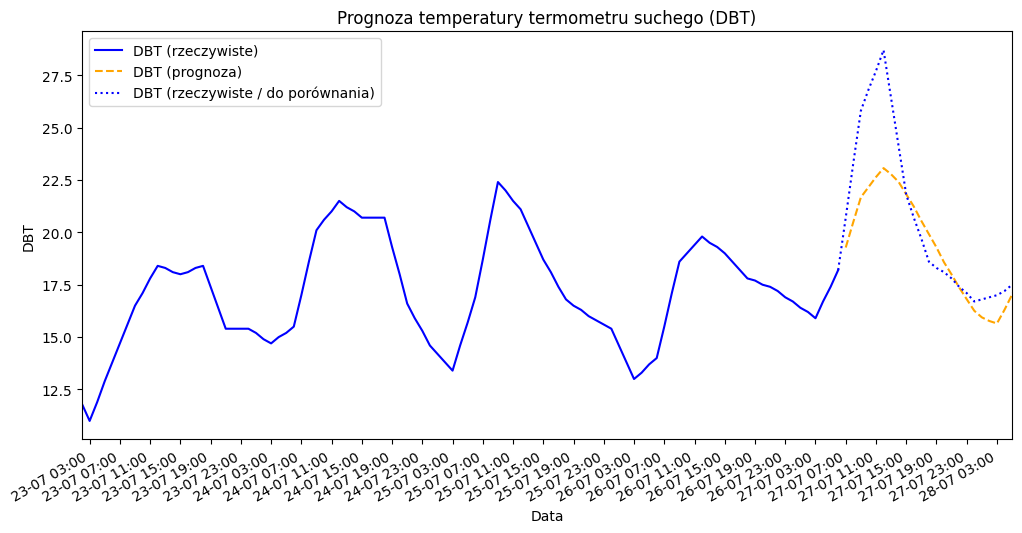

In [120]:
plt.figure(figsize=(12, 6))
plt.plot(df.index[-100 - n_hours:-n_hours+1], df['DBT'].values[-100 - n_hours:-n_hours+1], label='DBT (rzeczywiste)', color='blue')
plt.plot(forecast_level.index, forecast_level['DBT'], label='DBT (prognoza)', color='orange', linestyle='--')
plt.plot(df.index[-n_hours:], df['DBT'].values[-n_hours:], label='DBT (rzeczywiste / do porównania)', color='blue', linestyle=':')

plt.xlim(df.index[-100 - n_hours], df.index[-1])

plt.title('Prognoza temperatury termometru suchego (DBT)')
plt.xlabel('Data')
plt.ylabel('DBT')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=4))
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

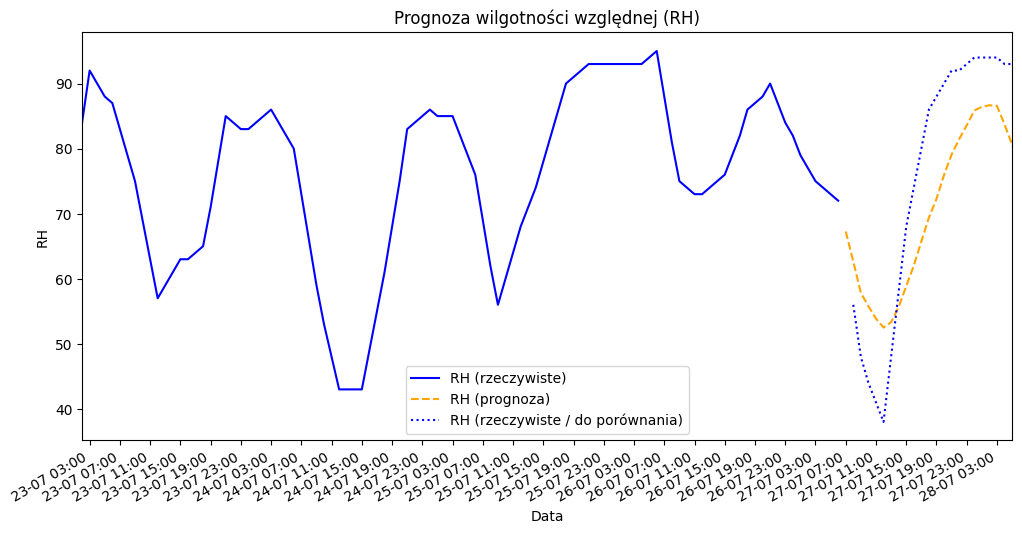

In [121]:
plt.figure(figsize=(12, 6))
plt.plot(df.index[-100 - n_hours:-n_hours+1], df['RH'].values[-100 - n_hours:-n_hours+1], label='RH (rzeczywiste)', color='blue')
plt.plot(forecast_level.index, forecast_level['RH'], label='RH (prognoza)', color='orange', linestyle='--')
plt.plot(df.index[-n_hours+2:], df['RH'].values[-n_hours+2:], label='RH (rzeczywiste / do porównania)', color='blue', linestyle=':')

plt.xlim(df.index[-100 - n_hours], df.index[-1])

plt.title('Prognoza wilgotności względnej (RH)')
plt.xlabel('Data')
plt.ylabel('RH')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=4))
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

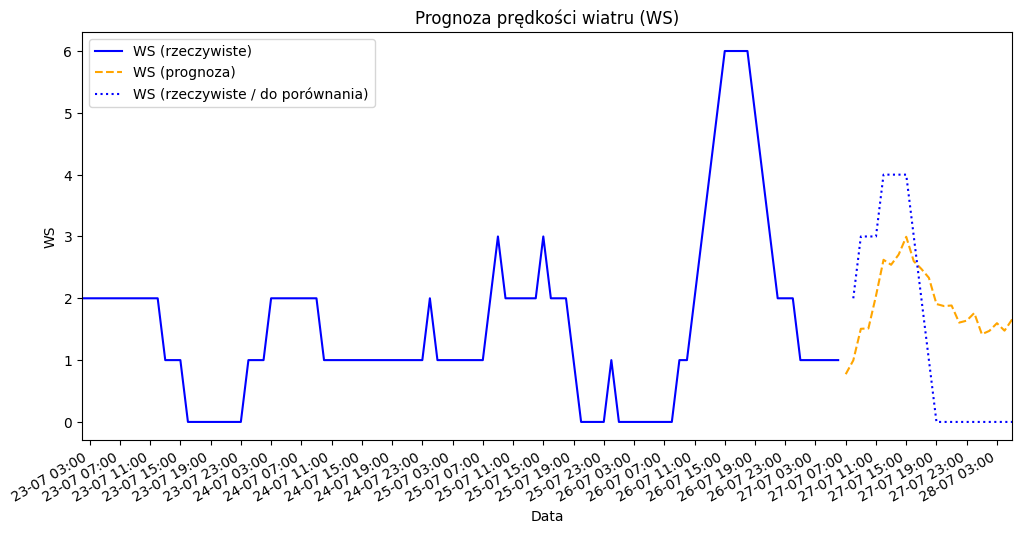

In [122]:
plt.figure(figsize=(12, 6))
plt.plot(df.index[-100 - n_hours:-n_hours+1], df['WS'].values[-100 - n_hours:-n_hours+1], label='WS (rzeczywiste)', color='blue')
plt.plot(forecast_level.index, forecast_level['WS'], label='WS (prognoza)', color='orange', linestyle='--')
plt.plot(df.index[-n_hours+2:], df['WS'].values[-n_hours+2:], label='WS (rzeczywiste / do porównania)', color='blue', linestyle=':')

plt.xlim(df.index[-100 - n_hours], df.index[-1])

plt.title('Prognoza prędkości wiatru (WS)')
plt.xlabel('Data')
plt.ylabel('WS')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=4))
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()